# Pronóstico de la evolución de pacientes con diabetes

## Descripción del problema real

Los tratamientos médicos están basados en las expectativas de recuperación o el avance de una enfermedad para tomar decisiones. En este caso, un equipo médico desea contar con pronósticos de pacientes con diabetes para tomar decisiones sobre su tratamiento.

## Descripción del problema en términos de los datos

Se desea determinar el progreso de la diabeteis un año hacia adelante a partir de las variables medidas para 442 pacientes. La información está almacenada en el archivo `datos/diabetes.csv`. Las variables medidas son: edad, sexo, indice de masa corporal, presión sanguinea y seis medidas de serum en la sangre. Se desea pronósticar el progreso de la enfermedad a partir de las variables dadas.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.

## Requerimientos

Usted debe:

* Determinar cuáles de las variables consideradas son relevantes para el problema.


* Determinar si hay alguna transformación de las variables de entrada o de salida que mejore el pronóstico del modelo.


* Construir un modelo de regresión lineal que sirva como base para construir un modelo de redes neuronales artificiales.



* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.

In [8]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
diabetes_set = pd.read_csv("datos/diabetes.csv")

# Selección de variables

In [3]:
X = diabetes_set.drop(["Y"],axis = 1)
y = diabetes_set["Y"]

##### Identificación de variables siginificativas con el estadístico t

In [4]:
x_sm = sm.add_constant(diabetes_set.drop("Y",axis=1))
model = sm.OLS(diabetes_set["Y"], x_sm)
results = model.fit()
pd.DataFrame(results.tvalues)

,0
const,59.061427
age,-0.167570
sex,-3.917184
bmi,7.813196
bp,4.958435
s1,-1.901163
s2,1.406187
s3,0.475431
s4,1.096538
s5,4.370394


In [5]:
x_sm = sm.add_constant(diabetes_set.drop(["Y","age"],axis=1))
model = sm.OLS(diabetes_set["Y"], x_sm)
results = model.fit()
pd.DataFrame(results.tvalues)

,0
const,59.127978
sex,-3.957639
bmi,7.823107
bp,5.023787
s1,-1.900534
s2,1.401996
s3,0.470042
s4,1.100334
s5,4.373286
s6,1.012756


In [6]:
x_sm = sm.add_constant(diabetes_set.drop(["Y","age","s3"],axis=1))
model = sm.OLS(diabetes_set["Y"], x_sm)
results = model.fit()
pd.DataFrame(results.tvalues)

,0
const,59.181242
sex,-3.984963
bmi,7.818292
bp,5.017619
s1,-3.031346
s2,1.602949
s4,1.054337
s5,5.777892
s6,1.029069


In [7]:
# ahora ya todas son significativamente mayores a 0

### Modelo de regresión lineal básico

In [13]:
# esta lista contiene las variables a borrar por cada método
variables_fuera = ["age","s3","Y"]

resultados_regresion = []

X_train, X_test, y_train, y_test = train_test_split(diabetes_set.drop(variables_fuera,axis=1),diabetes_set["Y"] , test_size=0.3, random_state=101)

lm = LinearRegression()
lm.fit(X_train,y_train)

predictions = lm.predict(X_test)
    
resultados_regresion.append([metrics.mean_absolute_error(y_test, predictions),
                                 metrics.mean_squared_error(y_test, predictions),
                                 np.sqrt(metrics.mean_squared_error(y_test, predictions))])
    
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)),"\n")
    
    

MAE: 45.967979334993935
MSE: 3350.1952123709443
RMSE: 57.88087086741996 



### Red neuronal con TensorFlow estimator

In [14]:
X_train, X_test, y_train, y_test = train_test_split(diabetes_set.drop(["Y"],axis=1),
                                                    diabetes_set["Y"],
                                                    test_size=0.2,
                                                    random_state=101)

X_train.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

In [15]:
sex = tf.feature_column.numeric_column('sex')
bmi = tf.feature_column.numeric_column('bmi')
bp = tf.feature_column.numeric_column('bp')
s1 = tf.feature_column.numeric_column('s1')
s2 = tf.feature_column.numeric_column('s2')
s4 = tf.feature_column.numeric_column('s4')
s5 = tf.feature_column.numeric_column('s5')
s6 = tf.feature_column.numeric_column('s6')

In [16]:
feat_cols = [sex, bmi, bp, s1, s2,s4, s5, s6]

In [17]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,
                                                 y=y_train ,
                                                 batch_size=10,
                                                 num_epochs=3000,
                                                 shuffle=True)

In [18]:
### Calibración del número de neuronas

In [19]:
neuronas_por_capa = [2,4,8,16,32,64]

In [20]:
from sklearn.metrics import mean_squared_error

history_neuron = []

for i in neuronas_por_capa:

    model = tf.estimator.DNNRegressor(hidden_units=[i,i,i,i,i],feature_columns=feat_cols)

    model.train(input_fn=input_func,steps=5000)

    predict_input_func = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        batch_size=10,
        num_epochs=1,
        shuffle=False)

    pred_gen = model.predict(predict_input_func)

    predictions = list(pred_gen)

    final_preds = []

    for pred in predictions:
        final_preds.append(pred['predictions'])   

    history_neuron.append(mean_squared_error(y_test,final_preds))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\andre\\AppData\\Local\\Temp\\tmpfr1hg3ri', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002A7B1A1B908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for up

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\andre\AppData\Local\Temp\tmpwl63bzyz\model.ckpt.
INFO:tensorflow:loss = 302506.06, step = 1
INFO:tensorflow:global_step/sec: 447.948
INFO:tensorflow:loss = 40195.977, step = 101 (0.226 sec)
INFO:tensorflow:global_step/sec: 671.57
INFO:tensorflow:loss = 32218.115, step = 201 (0.150 sec)
INFO:tensorflow:global_step/sec: 629.248
INFO:tensorflow:loss = 34467.527, step = 301 (0.161 sec)
INFO:tensorflow:global_step/sec: 641.389
INFO:tensorflow:loss = 43241.14, step = 401 (0.154 sec)
INFO:tensorflow:global_step/sec: 625.364
INFO:tensorflow:loss = 30042.203, step = 501 (0.160 sec)
INFO:tensorflow:global_step/sec: 599.143
INFO:tensorflow:loss = 43900.58, step = 601 (0.170 sec)
INFO:tensorflow:global_step/sec

INFO:tensorflow:global_step/sec: 608.928
INFO:tensorflow:loss = 35524.668, step = 1301 (0.163 sec)
INFO:tensorflow:global_step/sec: 610.093
INFO:tensorflow:loss = 28483.795, step = 1401 (0.164 sec)
INFO:tensorflow:global_step/sec: 617.597
INFO:tensorflow:loss = 21435.709, step = 1501 (0.164 sec)
INFO:tensorflow:global_step/sec: 625.345
INFO:tensorflow:loss = 20556.49, step = 1601 (0.160 sec)
INFO:tensorflow:global_step/sec: 610.105
INFO:tensorflow:loss = 47131.668, step = 1701 (0.163 sec)
INFO:tensorflow:global_step/sec: 631.88
INFO:tensorflow:loss = 15391.143, step = 1801 (0.159 sec)
INFO:tensorflow:global_step/sec: 583.574
INFO:tensorflow:loss = 56768.22, step = 1901 (0.170 sec)
INFO:tensorflow:global_step/sec: 625.345
INFO:tensorflow:loss = 15431.032, step = 2001 (0.161 sec)
INFO:tensorflow:global_step/sec: 613.86
INFO:tensorflow:loss = 46257.777, step = 2101 (0.161 sec)
INFO:tensorflow:global_step/sec: 621.514
INFO:tensorflow:loss = 13031.334, step = 2201 (0.162 sec)
INFO:tensorflo

INFO:tensorflow:global_step/sec: 610.036
INFO:tensorflow:loss = 42661.285, step = 2901 (0.162 sec)
INFO:tensorflow:global_step/sec: 625.393
INFO:tensorflow:loss = 36114.04, step = 3001 (0.162 sec)
INFO:tensorflow:global_step/sec: 621.512
INFO:tensorflow:loss = 38345.46, step = 3101 (0.158 sec)
INFO:tensorflow:global_step/sec: 610.068
INFO:tensorflow:loss = 18498.158, step = 3201 (0.165 sec)
INFO:tensorflow:global_step/sec: 633.236
INFO:tensorflow:loss = 38019.945, step = 3301 (0.157 sec)
INFO:tensorflow:global_step/sec: 633.351
INFO:tensorflow:loss = 37287.758, step = 3401 (0.158 sec)
INFO:tensorflow:global_step/sec: 625.289
INFO:tensorflow:loss = 16816.695, step = 3501 (0.161 sec)
INFO:tensorflow:global_step/sec: 629.361
INFO:tensorflow:loss = 23203.3, step = 3601 (0.159 sec)
INFO:tensorflow:global_step/sec: 610.105
INFO:tensorflow:loss = 53431.914, step = 3701 (0.162 sec)
INFO:tensorflow:global_step/sec: 633.223
INFO:tensorflow:loss = 23973.07, step = 3801 (0.160 sec)
INFO:tensorflow

INFO:tensorflow:global_step/sec: 633.222
INFO:tensorflow:loss = 29531.979, step = 4501 (0.158 sec)
INFO:tensorflow:global_step/sec: 641.404
INFO:tensorflow:loss = 24839.85, step = 4601 (0.157 sec)
INFO:tensorflow:global_step/sec: 649.766
INFO:tensorflow:loss = 27174.676, step = 4701 (0.156 sec)
INFO:tensorflow:global_step/sec: 617.6
INFO:tensorflow:loss = 32630.02, step = 4801 (0.159 sec)
INFO:tensorflow:global_step/sec: 645.569
INFO:tensorflow:loss = 21281.824, step = 4901 (0.157 sec)
INFO:tensorflow:Saving checkpoints for 5000 into C:\Users\andre\AppData\Local\Temp\tmpjd4asihg\model.ckpt.
INFO:tensorflow:Loss for final step: 43306.184.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\andre\AppData\Local\Temp\tmpjd4asihg\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Usi

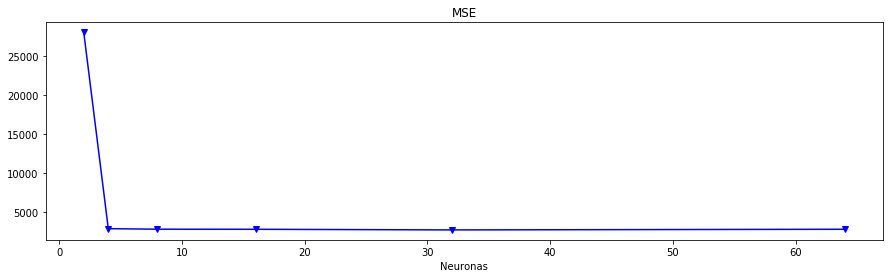

In [22]:
plt.figure(figsize=(15,4))
plt.xlabel('Neuronas')
plt.title("MSE")
plt.plot(neuronas_por_capa, history_neuron, 'bv-')


In [23]:
## Seleccionamos 4 neruonas 
capas = [[4],[4,4],[4,4,4],[4,4,4,4],[4,4,4,4,4],[4,4,4,4,4,4]]

In [24]:
history_layers = []

for i in capas:

    model = tf.estimator.DNNRegressor(hidden_units=i,feature_columns=feat_cols)

    model.train(input_fn=input_func,steps=5000)

    predict_input_func = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        batch_size=10,
        num_epochs=1,
        shuffle=False)

    pred_gen = model.predict(predict_input_func)

    predictions = list(pred_gen)

    final_preds = []

    for pred in predictions:
        final_preds.append(pred['predictions'])

    history_layers.append(mean_squared_error(y_test,final_preds))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\andre\\AppData\\Local\\Temp\\tmp5up6ph5o', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002A7B2B112E8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Checkp

INFO:tensorflow:global_step/sec: 763.795
INFO:tensorflow:loss = 162223.12, step = 301 (0.132 sec)
INFO:tensorflow:global_step/sec: 741.169
INFO:tensorflow:loss = 70053.234, step = 401 (0.136 sec)
INFO:tensorflow:global_step/sec: 608.714
INFO:tensorflow:loss = 37790.266, step = 501 (0.167 sec)
INFO:tensorflow:global_step/sec: 610.107
INFO:tensorflow:loss = 68049.766, step = 601 (0.160 sec)
INFO:tensorflow:global_step/sec: 595.539
INFO:tensorflow:loss = 25429.906, step = 701 (0.169 sec)
INFO:tensorflow:global_step/sec: 602.756
INFO:tensorflow:loss = 30620.254, step = 801 (0.166 sec)
INFO:tensorflow:global_step/sec: 602.42
INFO:tensorflow:loss = 31485.98, step = 901 (0.166 sec)
INFO:tensorflow:global_step/sec: 599.146
INFO:tensorflow:loss = 42309.3, step = 1001 (0.167 sec)
INFO:tensorflow:global_step/sec: 613.847
INFO:tensorflow:loss = 47830.27, step = 1101 (0.164 sec)
INFO:tensorflow:global_step/sec: 595.614
INFO:tensorflow:loss = 79401.58, step = 1201 (0.166 sec)
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 633.254
INFO:tensorflow:loss = 23643.508, step = 1901 (0.157 sec)
INFO:tensorflow:global_step/sec: 621.531
INFO:tensorflow:loss = 41069.02, step = 2001 (0.160 sec)
INFO:tensorflow:global_step/sec: 641.329
INFO:tensorflow:loss = 24538.684, step = 2101 (0.157 sec)
INFO:tensorflow:global_step/sec: 637.305
INFO:tensorflow:loss = 23850.834, step = 2201 (0.159 sec)
INFO:tensorflow:global_step/sec: 621.534
INFO:tensorflow:loss = 55340.242, step = 2301 (0.159 sec)
INFO:tensorflow:global_step/sec: 633.233
INFO:tensorflow:loss = 49703.383, step = 2401 (0.157 sec)
INFO:tensorflow:global_step/sec: 621.452
INFO:tensorflow:loss = 45835.6, step = 2501 (0.163 sec)
INFO:tensorflow:global_step/sec: 633.34
INFO:tensorflow:loss = 16832.883, step = 2601 (0.158 sec)
INFO:tensorflow:global_step/sec: 613.787
INFO:tensorflow:loss = 9724.113, step = 2701 (0.162 sec)
INFO:tensorflow:global_step/sec: 629.314
INFO:tensorflow:loss = 21989.15, step = 2801 (0.158 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 645.536
INFO:tensorflow:loss = 222770.1, step = 3501 (0.156 sec)
INFO:tensorflow:global_step/sec: 637.259
INFO:tensorflow:loss = 227740.33, step = 3601 (0.156 sec)
INFO:tensorflow:global_step/sec: 628.995
INFO:tensorflow:loss = 351758.7, step = 3701 (0.160 sec)
INFO:tensorflow:global_step/sec: 622.404
INFO:tensorflow:loss = 321555.12, step = 3801 (0.160 sec)
INFO:tensorflow:global_step/sec: 629.252
INFO:tensorflow:loss = 317519.16, step = 3901 (0.159 sec)
INFO:tensorflow:global_step/sec: 629.279
INFO:tensorflow:loss = 289394.5, step = 4001 (0.159 sec)
INFO:tensorflow:global_step/sec: 621.485
INFO:tensorflow:loss = 320230.94, step = 4101 (0.163 sec)
INFO:tensorflow:global_step/sec: 625.397
INFO:tensorflow:loss = 295919.75, step = 4201 (0.159 sec)
INFO:tensorflow:global_step/sec: 621.47
INFO:tensorflow:loss = 185257.11, step = 4301 (0.162 sec)
INFO:tensorflow:global_step/sec: 633.235
INFO:tensorflow:loss = 306299.8, step = 4401 (0.156 sec)
INFO:tensorflow

INFO:tensorflow:Loss for final step: 56249.984.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\andre\AppData\Local\Temp\tmp74h8u8oy\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\andre\\AppData\\Local\\Temp\\tmpf0a5pkzw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.pyth

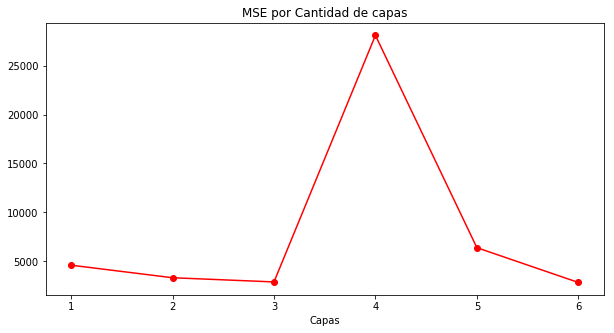

In [31]:
# seleccionamos el valor de 3

plt.figure(figsize=(10,5))
plt.xlabel('Capas')
plt.title("MSE por Cantidad de capas")
plt.plot([1,2,3,4,5,6], history_layers, 'ro-')


#### Modelo final con la Api.estimator:
     * Variables          [sex, bmi, bp, s1, s2, s4, s5, s6]
     * Capas              3
     * Neuronas por capa  4

In [26]:
tf.reset_default_graph()

feat_cols = [sex, bmi, bp, s1, s2, s4, s5, s6]

model = tf.estimator.DNNRegressor(hidden_units=[4,4,4],feature_columns=feat_cols)

model.train(input_fn=input_func,steps=5000)

predict_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_test,
      batch_size=10,
      num_epochs=1,
      shuffle=False)

pred_gen = model.predict(predict_input_func)

predictions = list(pred_gen)

final_preds = []

for pred in predictions:
    final_preds.append(pred['predictions'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\andre\\AppData\\Local\\Temp\\tmpoq_qxstw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002A7B2BBA8D0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Checkp

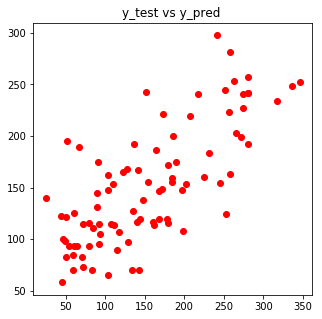

In [28]:
plt.figure(figsize=(5,5))
plt.title("y_test vs y_pred ")
plt.scatter(y_test,final_preds,color="red")

In [29]:
mae_nn =  metrics.mean_absolute_error(y_test, final_preds)
mse_nn =  metrics.mean_squared_error(y_test, final_preds)
rmse_nn = np.sqrt(metrics.mean_squared_error(y_test, final_preds))

print(mae_nn,mse_nn,rmse_nn)

43.63813164528836 2855.1699065206785 53.43378993222059


### Cross Validation

In [52]:
X = diabetes_set.drop(["Y"],axis = 1).values
y = diabetes_set["Y"].values

In [139]:
def cross_validation(train_index, test_index,X,y):    
    
    X_train, X_test = pd.DataFrame(X[train_index]), pd.DataFrame(X[test_index])
    y_train, y_test = pd.DataFrame(y[train_index]), pd.DataFrame(y[test_index])
    
    X_train.columns = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
    X_test.columns = X_train.columns = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
    #y_train.columns = ["Y"]
    #y_test.columns = ["Y"]
    
    sex = tf.feature_column.numeric_column('sex')
    bmi = tf.feature_column.numeric_column('bmi')
    bp = tf.feature_column.numeric_column('bp')
    s1 = tf.feature_column.numeric_column('s1')
    s2 = tf.feature_column.numeric_column('s2')
    s4 = tf.feature_column.numeric_column('s4')
    s5 = tf.feature_column.numeric_column('s5')
    s6 = tf.feature_column.numeric_column('s6')

    feat_cols = [sex, bmi, bp, s1, s2,s4, s5, s6]

    input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,
                                                     y= y_train[0],
                                                     batch_size=10,
                                                     num_epochs=3000,
                                                     shuffle=False)
    
    model = tf.estimator.DNNRegressor(hidden_units=[4,4,4],feature_columns=feat_cols)

    model.train(input_fn=input_func,steps=5000)

    predict_input_func = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        batch_size=10,
        num_epochs=1,
        shuffle=False)

    pred_gen = model.predict(predict_input_func)

    predictions = list(pred_gen)

    final_preds = []

    for pred in predictions:
        final_preds.append(pred['predictions'])   

    return metrics.mean_squared_error(y_test, final_preds)
   

In [140]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4)

resultado_cross = []

for train_index, test_index in kf.split(X):    

    resultado_cross.append(cross_validation(train_index,test_index,X,y))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\andre\\AppData\\Local\\Temp\\tmp1jy9qjvg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002A7BC25F518>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Checkp

INFO:tensorflow:global_step/sec: 629.293
INFO:tensorflow:loss = 39941.89, step = 301 (0.160 sec)
INFO:tensorflow:global_step/sec: 580.645
INFO:tensorflow:loss = 75029.125, step = 401 (0.170 sec)
INFO:tensorflow:global_step/sec: 676.061
INFO:tensorflow:loss = 57545.875, step = 501 (0.148 sec)
INFO:tensorflow:global_step/sec: 604.437
INFO:tensorflow:loss = 36826.81, step = 601 (0.169 sec)
INFO:tensorflow:global_step/sec: 581.721
INFO:tensorflow:loss = 35386.395, step = 701 (0.171 sec)
INFO:tensorflow:global_step/sec: 571.761
INFO:tensorflow:loss = 26011.848, step = 801 (0.171 sec)
INFO:tensorflow:global_step/sec: 583.107
INFO:tensorflow:loss = 19474.344, step = 901 (0.173 sec)
INFO:tensorflow:global_step/sec: 610.085
INFO:tensorflow:loss = 54711.9, step = 1001 (0.164 sec)
INFO:tensorflow:global_step/sec: 610.163
INFO:tensorflow:loss = 47560.465, step = 1101 (0.164 sec)
INFO:tensorflow:global_step/sec: 621.427
INFO:tensorflow:loss = 24213.379, step = 1201 (0.159 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 625.351
INFO:tensorflow:loss = 42089.47, step = 1901 (0.162 sec)
INFO:tensorflow:global_step/sec: 645.539
INFO:tensorflow:loss = 25583.629, step = 2001 (0.153 sec)
INFO:tensorflow:global_step/sec: 617.675
INFO:tensorflow:loss = 24706.38, step = 2101 (0.162 sec)
INFO:tensorflow:global_step/sec: 629.251
INFO:tensorflow:loss = 35384.047, step = 2201 (0.161 sec)
INFO:tensorflow:global_step/sec: 621.472
INFO:tensorflow:loss = 36715.992, step = 2301 (0.160 sec)
INFO:tensorflow:global_step/sec: 621.474
INFO:tensorflow:loss = 49500.223, step = 2401 (0.162 sec)
INFO:tensorflow:global_step/sec: 641.434
INFO:tensorflow:loss = 46183.223, step = 2501 (0.154 sec)
INFO:tensorflow:global_step/sec: 625.319
INFO:tensorflow:loss = 41656.016, step = 2601 (0.160 sec)
INFO:tensorflow:global_step/sec: 633.167
INFO:tensorflow:loss = 39671.414, step = 2701 (0.159 sec)
INFO:tensorflow:global_step/sec: 621.618
INFO:tensorflow:loss = 33089.785, step = 2801 (0.163 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 568.509
INFO:tensorflow:loss = 28654.133, step = 3501 (0.175 sec)
INFO:tensorflow:global_step/sec: 610.104
INFO:tensorflow:loss = 35812.758, step = 3601 (0.166 sec)
INFO:tensorflow:global_step/sec: 546.765
INFO:tensorflow:loss = 43356.504, step = 3701 (0.183 sec)
INFO:tensorflow:global_step/sec: 595.518
INFO:tensorflow:loss = 30270.44, step = 3801 (0.167 sec)
INFO:tensorflow:global_step/sec: 588.399
INFO:tensorflow:loss = 27660.34, step = 3901 (0.168 sec)
INFO:tensorflow:global_step/sec: 627.892
INFO:tensorflow:loss = 21605.178, step = 4001 (0.159 sec)
INFO:tensorflow:global_step/sec: 549.727
INFO:tensorflow:loss = 19822.797, step = 4101 (0.186 sec)
INFO:tensorflow:global_step/sec: 578.393
INFO:tensorflow:loss = 19167.754, step = 4201 (0.172 sec)
INFO:tensorflow:global_step/sec: 578.38
INFO:tensorflow:loss = 16432.193, step = 4301 (0.170 sec)
INFO:tensorflow:global_step/sec: 613.517
INFO:tensorflow:loss = 24714.365, step = 4401 (0.165 sec)
INFO:tensorfl

In [141]:
print("MSE Cross validation: ", np.array(resultado_cross).sum()/len(resultado_cross))

MSE Cross validation:  2990.2184432487657
